In [1]:
import os
import pickle
from collections.abc import Callable
from pathlib import Path
from typing import Any

import cv2
import numpy as np
import torch
from torch import Tensor
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
from srcnn import SRCNN

In [3]:
class VideoFrameDataset(Dataset):
    def __init__(
        self, video_path: str, transform: Callable[[np.ndarray], Any] = None
    ) -> None:
        self.frames: list[np.ndarray] = []
        capture = cv2.VideoCapture(video_path)
        while True:
            success, frame = capture.read()
            if not success:
                break
            self.frames.append(frame)
        self.transform = transform

    def __len__(self) -> int:
        return len(self.frames)

    def __getitem__(self, index: int):
        frame = self.frames[index]
        if self.transform:
            frame = self.transform(frame)
        return frame

In [4]:
target_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((720, 1280)),
        v2.ToDtype(torch.float32, scale=False),
    ]
)

input_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((240, 427)),
        v2.Resize((720, 1280)),
        v2.ToDtype(torch.float32, scale=False),
    ]
)


def transform(frame: np.ndarray) -> tuple[Tensor, Tensor]:
    return input_transform(frame), target_transform(frame)

In [5]:
video_path = os.fspath(Path.cwd().glob("*.mp4").__next__())
dataset = VideoFrameDataset(video_path, transform)
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    pin_memory_device="cuda",
)

In [6]:
model_args = {
    "f1": 9,
    "f2": 1,
    "f3": 5,
    "n1": 64,
    "n2": 32,
    "qconfig": torch.ao.quantization.get_default_qat_qconfig("x86"),
}
device = "cuda"

In [7]:
model = SRCNN(**model_args).to(device)
optimizer = Adam(model.parameters(), lr=2e-4)

model.train()
epoch_losses = []
for epoch in range(1, 20 + 1):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    batch_losses = []

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, quant=False)
        loss = F.mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    print(f"Epoch loss: {epoch_loss}")

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        print("Saving best.pth")
        torch.save(model.state_dict(), "best.pth")

    epoch_losses.append(epoch_loss)

Epoch 1: 100%|██████████| 151/151 [00:30<00:00,  4.99it/s, batch_loss=197]   


Epoch loss: 3166.5734198361833
Saving best.pth


Epoch 2: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=74.8]


Epoch loss: 134.7137427424753
Saving best.pth


Epoch 3: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=67.8]


Epoch loss: 79.61456902611334
Saving best.pth


Epoch 4: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=58.7]


Epoch loss: 62.39062089477943
Saving best.pth


Epoch 5: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=65.1]


Epoch loss: 53.130986573680346
Saving best.pth


Epoch 6: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=39.4]


Epoch loss: 48.184447711666685
Saving best.pth


Epoch 7: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, batch_loss=68.1]


Epoch loss: 44.20531766777796
Saving best.pth


Epoch 8: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=39.4]


Epoch loss: 41.36244085450836
Saving best.pth


Epoch 9: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=30.6]


Epoch loss: 37.044069037532175
Saving best.pth


Epoch 10: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=33]  


Epoch loss: 38.533558599206785


Epoch 11: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=29.5]


Epoch loss: 32.770449821522696
Saving best.pth


Epoch 12: 100%|██████████| 151/151 [00:28<00:00,  5.21it/s, batch_loss=28.7]


Epoch loss: 32.893905968066086


Epoch 13: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, batch_loss=31.9]


Epoch loss: 30.753943373825376
Saving best.pth


Epoch 14: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=23.2]


Epoch loss: 29.41624798048411
Saving best.pth


Epoch 15: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=30]  


Epoch loss: 31.577379504576424


Epoch 16: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, batch_loss=35]  


Epoch loss: 29.581886424134108


Epoch 17: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=18]  


Epoch loss: 30.564475318453958


Epoch 18: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, batch_loss=37.8]


Epoch loss: 27.376762326979478
Saving best.pth


Epoch 19: 100%|██████████| 151/151 [00:28<00:00,  5.21it/s, batch_loss=29.1]


Epoch loss: 27.44205184961786


Epoch 20: 100%|██████████| 151/151 [00:28<00:00,  5.21it/s, batch_loss=74.6]

Epoch loss: 39.263662995092126


Text(0, 0.5, 'Loss')

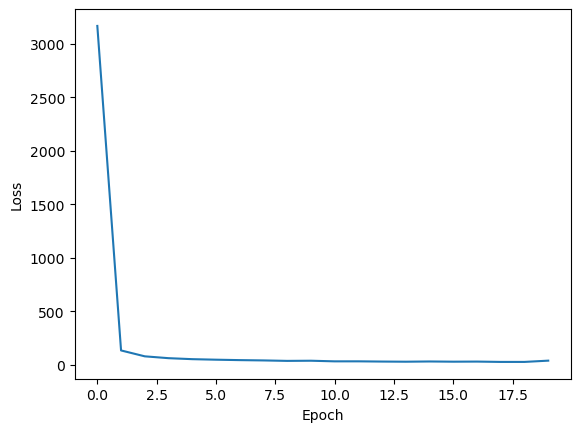

In [8]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [9]:
model = SRCNN(**model_args).to(device)
model.load_state_dict(torch.load("best.pth"))
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)

optimizer = Adam(model_qat.parameters(), lr=4e-5)

epoch_losses = []
for epoch in range(1, 10 + 1):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    batch_losses = []

    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_qat(inputs, quant=True)
        loss = F.mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    print(f"Epoch loss: {epoch_loss}")

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        print("Saving best_qat.pth")
        torch.save(model_qat.state_dict(), "best_qat.pth")

    epoch_losses.append(epoch_loss)

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
Epoch 1:   0%|          | 0/151 [00:00<?, ?it/s]/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Us

Epoch loss: 42.271752224852705
Saving best_qat.pth


Epoch 2: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=38.1]


Epoch loss: 39.174862678477304
Saving best_qat.pth


Epoch 3: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=48.3]


Epoch loss: 39.01299861882696
Saving best_qat.pth


Epoch 4: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=34.6]


Epoch loss: 38.33563092212803
Saving best_qat.pth


Epoch 5: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=39.3]


Epoch loss: 41.14637609822861


Epoch 6: 100%|██████████| 151/151 [00:34<00:00,  4.41it/s, batch_loss=39.1]


Epoch loss: 38.823707605829306


Epoch 7: 100%|██████████| 151/151 [00:34<00:00,  4.43it/s, batch_loss=38.1]


Epoch loss: 37.63515354939644
Saving best_qat.pth


Epoch 8: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=36.9]


Epoch loss: 38.62011774328371


Epoch 9: 100%|██████████| 151/151 [00:34<00:00,  4.42it/s, batch_loss=38.9]


Epoch loss: 39.22080234502325


Epoch 10: 100%|██████████| 151/151 [00:34<00:00,  4.40it/s, batch_loss=38]  

Epoch loss: 39.95077133178711


Text(0, 0.5, 'Loss')

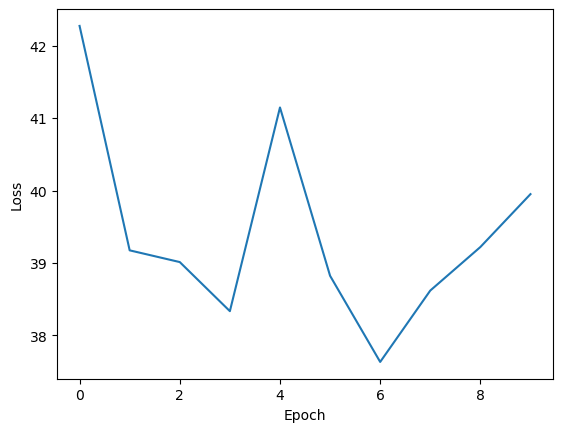

In [10]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [17]:
model = SRCNN(**model_args).to(device)
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.load_state_dict(torch.load("best_qat.pth"))
model_qat.cpu()
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
torch.save(model_converted.state_dict(), "converted.pth")

In [18]:
def show_image(image: np.ndarray | Tensor) -> None:
    if isinstance(image, Tensor):
        image = image.cpu().detach().numpy()
    if image.shape[0] == 1:
        image = image.squeeze(0)
    if image.shape[0] == 3:
        image = image.transpose((1, 2, 0))
    image = image.clip(0, 255).astype(np.uint8)
    plt.axis("off")
    plt.imshow(image)

Text(0.5, 1.0, 'Target')

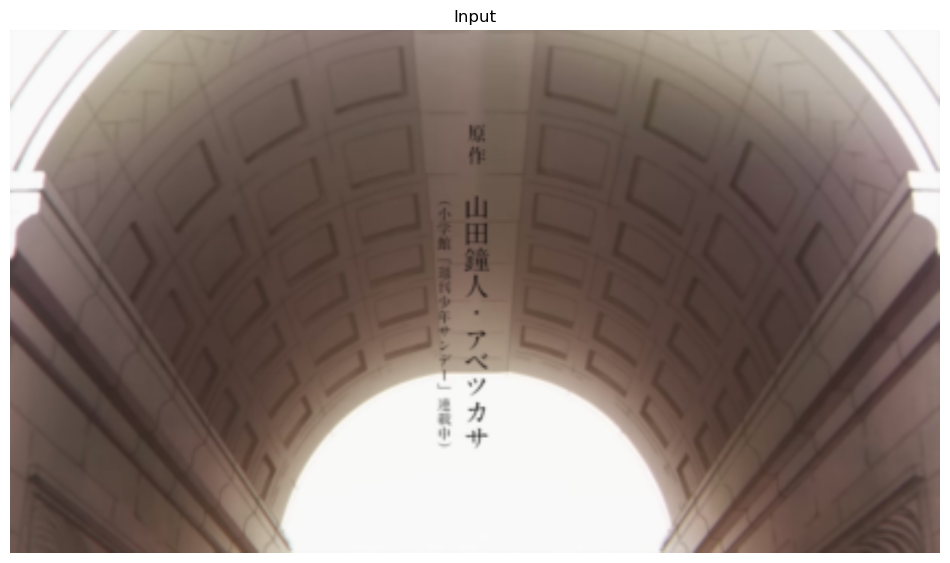

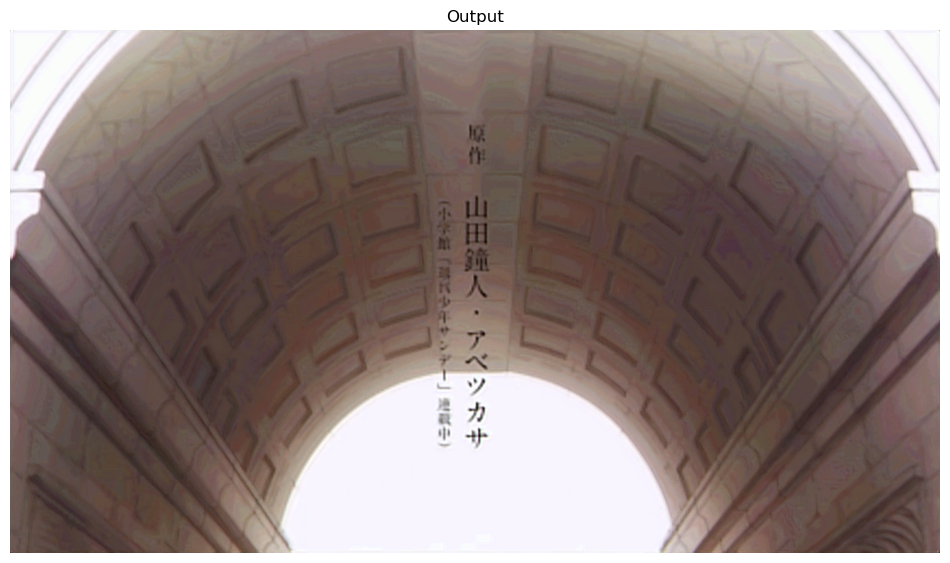

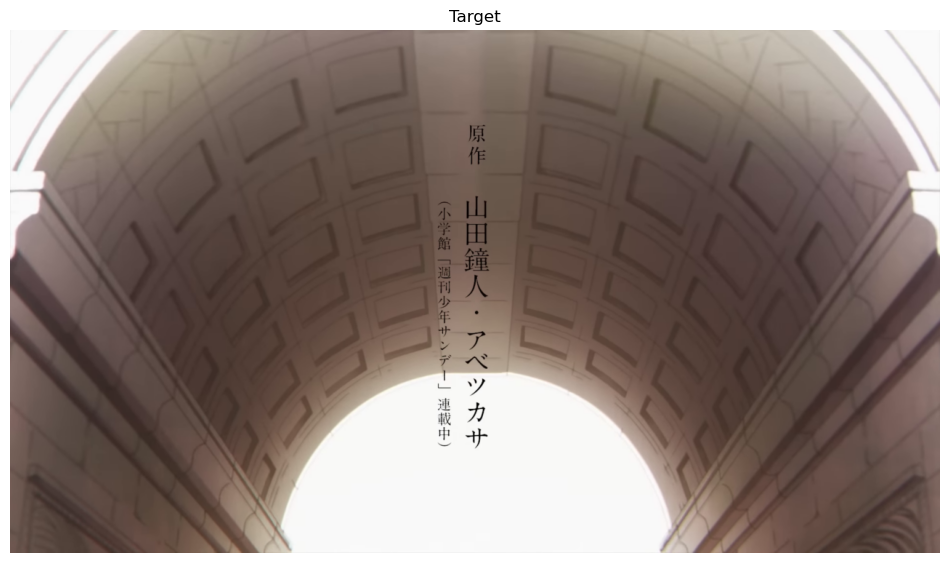

In [19]:
model = SRCNN(**model_args)
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
model_converted.load_state_dict(torch.load("converted.pth"))

test_input, test_target = dataset[100]
test_input = test_input.unsqueeze(0)
test_output = model_converted(test_input, quant=True)

FIGURE_SIZE = (12, 8)

plt.figure(figsize=FIGURE_SIZE)
show_image(test_input)
plt.title("Input")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_output)
plt.title("Output")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_target)
plt.title("Target")

In [69]:
s = [30, 23, 23]

u = []
v = []
weights = []

x_scale_keys = ["quant.scale", "conv_layers.0.scale", "conv_layers.1.scale"]
x_zero_point_keys = [
    "quant.zero_point",
    "conv_layers.0.zero_point",
    "conv_layers.2.zero_point",
]

for i in range(3):
    conv_layers_weight = model_converted.state_dict()[f"conv_layers.{i}.weight"]
    bias = model_converted.state_dict()[f"conv_layers.{i}.bias"]

    x_scale = model_converted.state_dict()[x_scale_keys[i]]
    y_scale = model_converted.state_dict()[f"conv_layers.{i}.scale"]
    A_scale = conv_layers_weight.q_per_channel_scales()

    u.append(x_scale / y_scale * A_scale * (2 ** s[i]))
    v.append((bias / y_scale) * (2 ** s[i]))

    A_q = conv_layers_weight.int_repr()
    x_0 = model_converted.state_dict()[x_zero_point_keys[i]]

    weight = A_q * u[i].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    weights.append(weight)

weights[0] = weights[0] / model_converted.state_dict()["quant.scale"]
weights[2] = weights[2] * y_scale

Text(0.5, 1.0, 'Output')

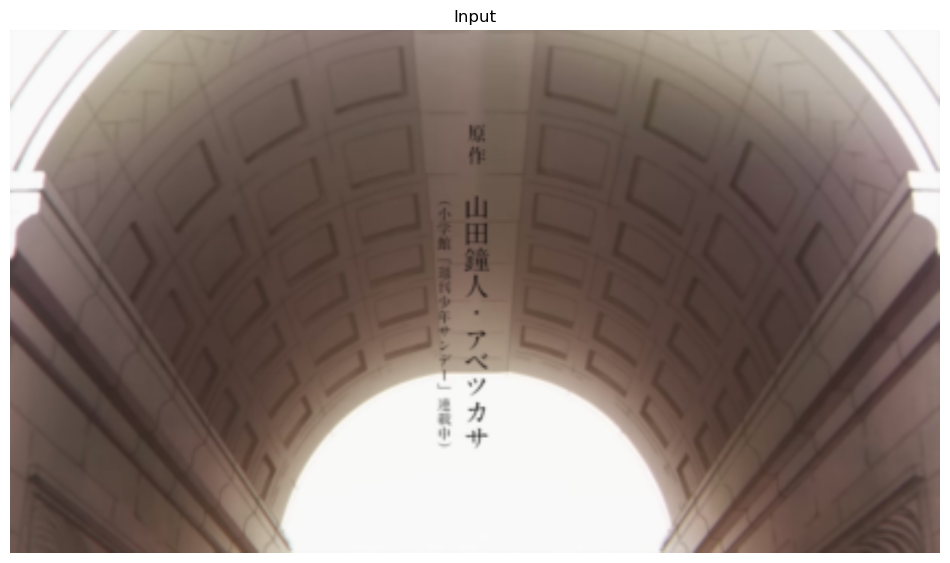

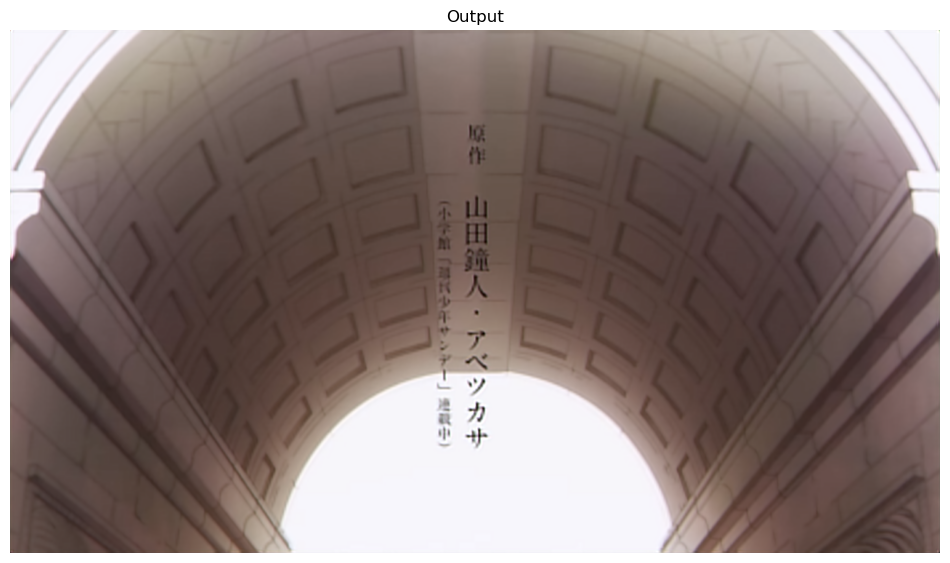

In [72]:
ACTIVATION_SHIFT = 6

ACTIVATION_WIDTH = 16
ACTIVATION_MIN = -(2 ** (ACTIVATION_WIDTH - 1))
ACTIVATION_MAX = 2 ** (ACTIVATION_WIDTH - 1) - 1

WEIGHT_WIDTH = 25
WEIGHT_MIN = -(2 ** (WEIGHT_WIDTH - 1))
WEIGHT_MAX = 2 ** (WEIGHT_WIDTH - 1) - 1

DSP_OUTPUT_WIDTH = 48
DSP_OUTPUT_MIN = -(2 ** (DSP_OUTPUT_WIDTH - 1))
DSP_OUTPUT_MAX = 2 ** (DSP_OUTPUT_WIDTH - 1) - 1

test_output = test_input.double() * (2**ACTIVATION_SHIFT)

for i, weight in enumerate(weights):
    assert weight.min() >= WEIGHT_MIN, f"Weight {i} min: {weight.min()}"
    assert weight.max() <= WEIGHT_MAX, f"Weight {i} max: {weight.max()}"

    test_output = (
        F.conv2d(
            test_output, weight.double().round(), v[i].double().round(), padding="same"
        )
        .double()
        .round()
    )
    assert test_output.min() >= DSP_OUTPUT_MIN, f"Output {i} min: {test_output.min()}"
    assert test_output.max() <= DSP_OUTPUT_MAX, f"Output {i} max: {test_output.max()}"

    test_output = F.relu(test_output * (2 ** -s[i])).double().floor()
    assert test_output.min() >= ACTIVATION_MIN, f"Output {i} min: {test_output.min()}"
    assert test_output.max() <= ACTIVATION_MAX, f"Output {i} max: {test_output.max()}"

test_output = (test_output * (2**-ACTIVATION_SHIFT)).double().floor()

plt.figure(figsize=FIGURE_SIZE)
show_image(test_input)
plt.title("Input")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_output)
plt.title("Output")

In [73]:
with open("weights.pkl", "wb") as fp:
    pickle.dump(weights, fp)
with open("biases.pkl", "wb") as fp:
    pickle.dump(v, fp)